In [1]:
!pip install pandas scikit-learn matplotlib


X_train shape: (328, 10, 3)
X_test shape: (83, 10, 3)
Epoch 1/50
10/10 [==============================] - 3s 68ms/step - loss: 0.2500 - val_loss: 0.0698
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1233 - val_loss: 0.0834
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.1168 - val_loss: 0.0718
Epoch 4/50
10/10 [==============================] - 0s 13ms/step - loss: 0.1075 - val_loss: 0.0696
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 0.1023 - val_loss: 0.0731
Epoch 6/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0981 - val_loss: 0.0745
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0947 - val_loss: 0.0733
Epoch 8/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0920 - val_loss: 0.0734
Epoch 9/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0881 - val_loss: 0.0729
Epoch 10/50
10/10 [==============================] - 0s

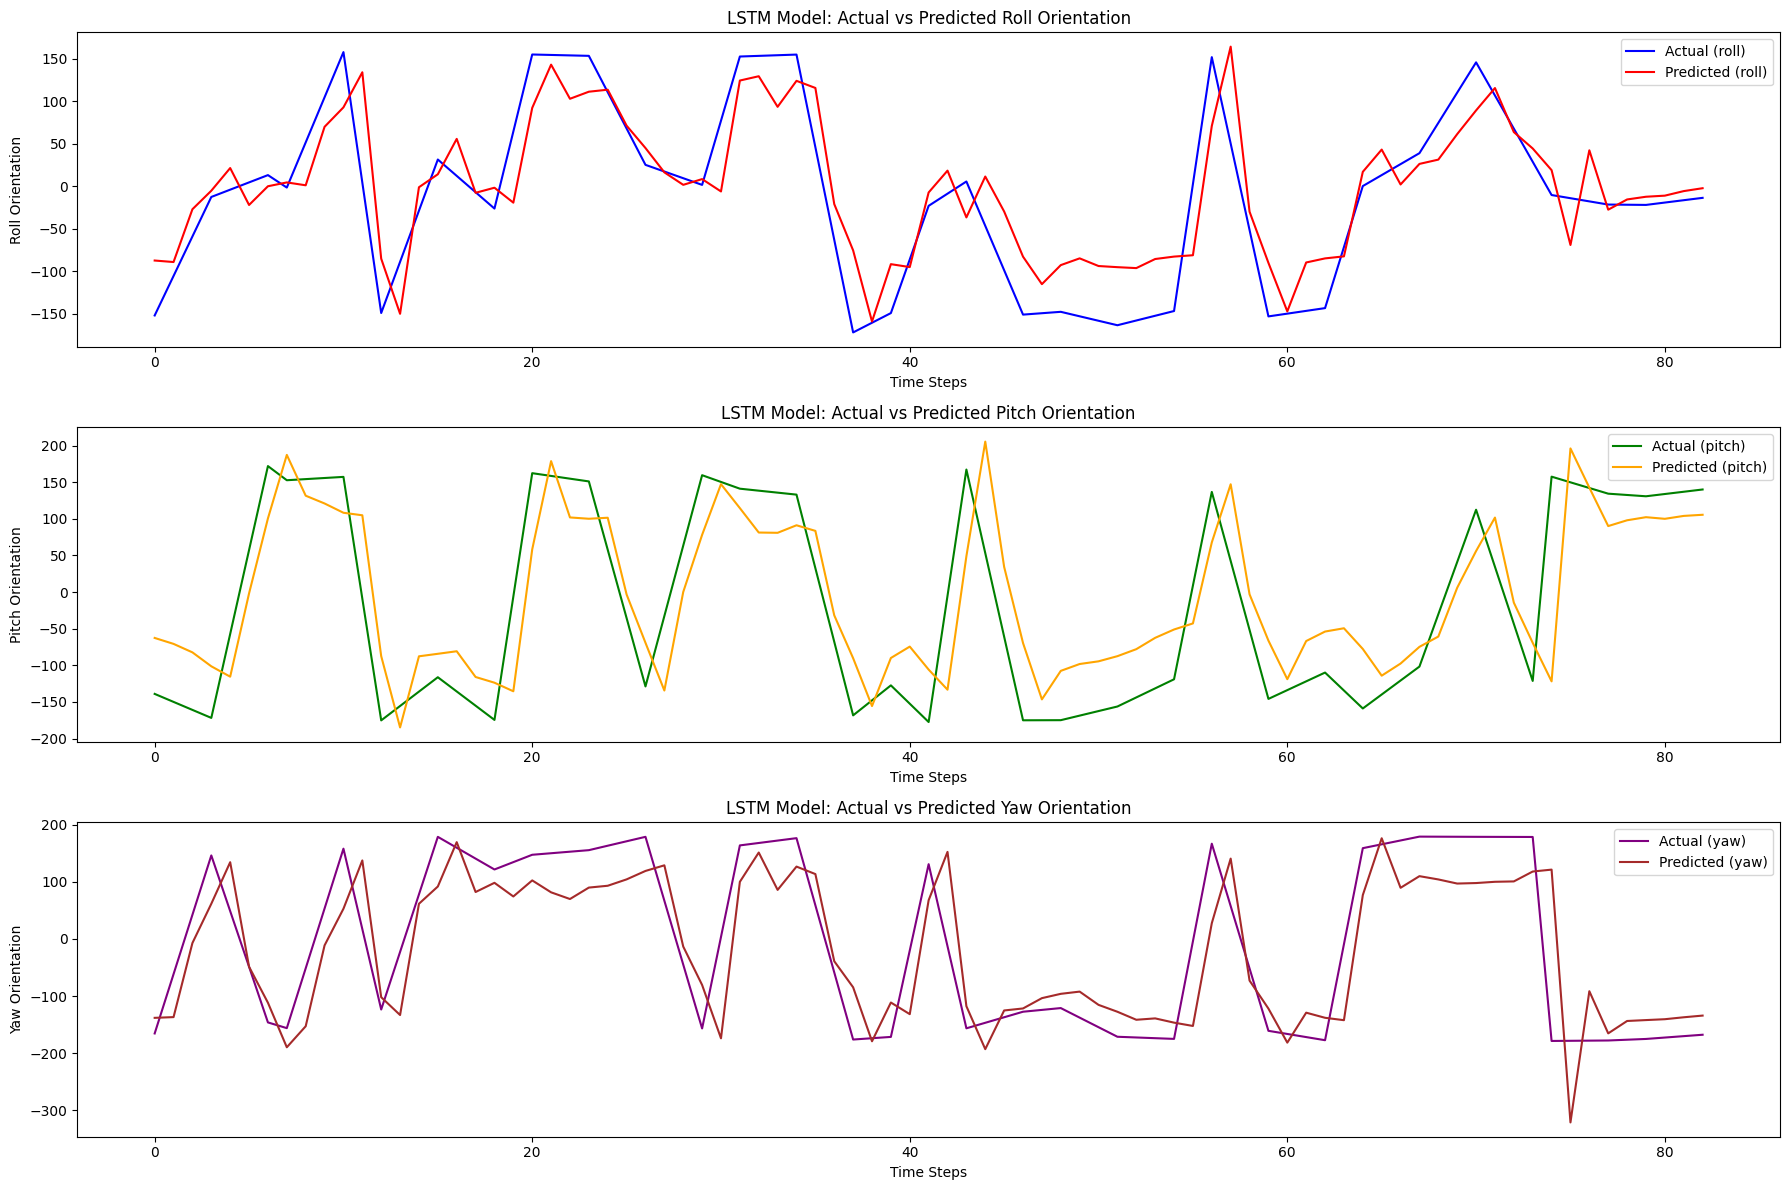

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Read the text file and preprocess the data
file_path = 'database_aanchal.txt'
columns = ['roll', 'pitch', 'yaw', 'timestamp']
data = pd.read_csv(file_path, header=None, names=columns, sep=', ', engine='python')

# Convert timestamp to datetime format
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%H:%M:%S:%f')

# Sort data by timestamp (if not already sorted)
data.sort_values(by='timestamp', inplace=True)
data.reset_index(drop=True, inplace=True)

# Resample the data to handle missing values or irregular time intervals
data_resampled = data.set_index('timestamp').resample('0.06S').mean().interpolate()

# Extract orientation values (roll, pitch, yaw)
orientation_data = data_resampled[['roll', 'pitch', 'yaw']]

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
orientation_data_scaled = scaler.fit_transform(orientation_data)

# Function to prepare data for LSTM model
def prepare_data_for_lstm(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Set window size (number of time steps to look back)
window_size = 10  # Adjust based on your data and prediction horizon

# Prepare data for LSTM
X, y = prepare_data_for_lstm(orientation_data_scaled, window_size)

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Print shapes of input arrays
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Define LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))  # <-- Check input shape here
model.add(Dense(3))  # Output layer with 3 neurons (roll, pitch, yaw)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

# Plot actual vs predicted values for each orientation (roll, pitch, yaw)
plt.figure(figsize=(18, 12))

# Plot for Roll
plt.subplot(3, 1, 1)
plt.plot(y_test_inv[:, 0], label='Actual (roll)', color='blue')
plt.plot(predictions_inv[:, 0], label='Predicted (roll)', color='red')
plt.xlabel('Time Steps')
plt.ylabel('Roll Orientation')
plt.title('LSTM Model: Actual vs Predicted Roll Orientation')
plt.legend()

# Plot for Pitch
plt.subplot(3, 1, 2)
plt.plot(y_test_inv[:, 1], label='Actual (pitch)', color='green')
plt.plot(predictions_inv[:, 1], label='Predicted (pitch)', color='orange')
plt.xlabel('Time Steps')
plt.ylabel('Pitch Orientation')
plt.title('LSTM Model: Actual vs Predicted Pitch Orientation')
plt.legend()

# Plot for Yaw
plt.subplot(3, 1, 3)
plt.plot(y_test_inv[:, 2], label='Actual (yaw)', color='purple')
plt.plot(predictions_inv[:, 2], label='Predicted (yaw)', color='brown')
plt.xlabel('Time Steps')
plt.ylabel('Yaw Orientation')
plt.title('LSTM Model: Actual vs Predicted Yaw Orientation')
plt.legend()

plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()
